### Finding the vol fitting outliers
   * produce the ATM option spread in 2021
   * find <20 periods of spikes
   * go to CT to check the vol fitting curves
   * write down the summaries into confluence

In [85]:
from cdcqr.data.deribit.data_utils import quoto_and_trade_analysis
from datetime import datetime
import sys
import pandas as pd
from cdcqr.data.deribit.data_utils import get_spread_from_ATM_option_quote_data
from cdcqr.common.utils import parallel_jobs
from cdcqr.common.config import LOCAL_DATA_DIR
sys.path.append('C://github/cryptoderiv-quant/')

import matplotlib.pyplot as plt

In [21]:
from ct.utils import plot2

quoto_and_trade_analysis?

In [8]:
ret_dict, ret_df = quoto_and_trade_analysis(contract='BTC-25JUN21-60000-C', date='2021-04-18')

processing data BTC-25JUN21-60000-C 2021-04-18 deribit
'parse_optSymbol_col'  17.09 sec
'parse_time_col'  9.12 sec


In [10]:
ret_df.head()

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
0,deribit,BTC-25JUN21-60000-C,1618703998435000,1618704000429068,19.4,0.1465,0.1410,1.5,BTC,2021-06-25 08:00:00,...,2021-04-17 23:59:58.435,1641.0,0.0,NaN,False,0.14375,0.146105,NaN,NaN,0.0055
1,deribit,BTC-25JUN21-60000-C,1618704001335000,1618704001347292,19.4,0.1465,0.1405,19.4,BTC,2021-06-25 08:00:00,...,2021-04-18 00:00:01.335,1640.0,0.0,NaN,False,0.14350,0.143500,-0.001739,-0.017831,0.0060
2,deribit,BTC-25JUN21-60000-C,1618704004731000,1618704004741696,19.4,0.1465,0.1410,1.5,BTC,2021-06-25 08:00:00,...,2021-04-18 00:00:04.731,1640.0,0.0,NaN,False,0.14375,0.146105,0.001742,0.018155,0.0055
3,deribit,BTC-25JUN21-60000-C,1618704006360000,1618704006370906,19.4,0.1465,0.1400,0.7,BTC,2021-06-25 08:00:00,...,2021-04-18 00:00:06.360,1640.0,0.0,NaN,False,0.14325,0.146274,-0.003478,0.001152,0.0065
4,deribit,BTC-25JUN21-60000-C,1618704006460000,1618704006469206,19.4,0.1465,0.1405,1.5,BTC,2021-06-25 08:00:00,...,2021-04-18 00:00:06.460,1640.0,0.0,NaN,False,0.14350,0.146069,0.001745,-0.001396,0.0060


<AxesSubplot:xlabel='timestamp_dt'>

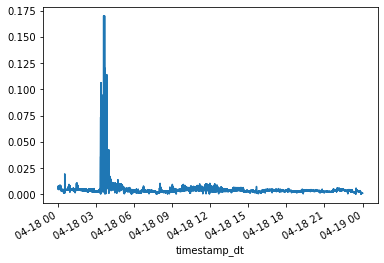

In [17]:
ret_df.set_index('timestamp_dt')['spread'].pipe(df2)

### 1) Load quote data, finding the ATM option, produce the spread at minutes level

In [86]:
def get_spread_from_ATM_option_quote_data(date):
    """
    load quote data -> find the ATM call -> calcuate spread, resample at 1 min level -> return the max spread time series
    """
    df = data_loader(exchange='deribit', date = date.strftime('%Y-%m-%d'), data_type='quotes', symbol='OPTIONS', )
    df1 = df[['symbol','timestamp','ask_price','bid_price']]
    df2 = df1[df1['symbol'].str.contains('BTC') & df1['symbol'].str.contains('-C')]
    df2['spread'] = df2['ask_price'] - df2['bid_price']
    df3 = df2[['symbol','timestamp','spread']]
    ATM_call = df3.groupby('symbol')['spread'].count().sort_values(ascending=False).index[0]
    df4 = df3.query('symbol==@ATM_call')
    df4['dt'] = pd.to_datetime(df4['timestamp'], unit='us')
    df5 = df4.set_index('dt').resample('1T')['spread'].max()
    df5 = df5[df5.index>=date]
    return df5

In [2]:
from cdcqr.data.dataloader import data_loader
dates = pd.date_range(datetime(2021,1,1), datetime(2021,10,28))
date = dates[0]

In [3]:
get_spread_from_ATM_option_quote_data(date)

dt
2021-01-01 00:00:00    0.0460
2021-01-01 00:01:00    0.0400
2021-01-01 00:02:00    0.0410
2021-01-01 00:03:00    0.0405
2021-01-01 00:04:00    0.0395
                        ...  
2021-01-01 23:55:00    0.0345
2021-01-01 23:56:00    0.0375
2021-01-01 23:57:00    0.0380
2021-01-01 23:58:00    0.0380
2021-01-01 23:59:00    0.0385
Freq: T, Name: spread, Length: 1440, dtype: float64

### 2) run the above function in parallel

In [31]:
dates = pd.date_range(datetime(2021,1,1), datetime(2021,4,1))
dates2 = pd.date_range(datetime(2021,4,2), datetime(2021,7,1))
dates3 = pd.date_range(datetime(2021,7,2), datetime(2021,10,27))


In [32]:
ret_dict = parallel_jobs(get_spread_from_ATM_option_quote_data, dates3)

processing individual tasks 99.152542%

'parallel_jobs'  279.24 sec


In [33]:
ret_df = pd.concat(ret_dict.values()).sort_index()

In [34]:
ret_df_08_10= ret_df.copy()

In [27]:
ret_df_04_07 = ret_df.copy()

<AxesSubplot:xlabel='dt'>

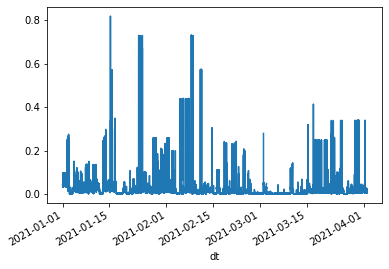

In [21]:
ret_df.plot()

In [22]:
ret_df_01_03 = ret_df.copy()

<AxesSubplot:xlabel='dt'>

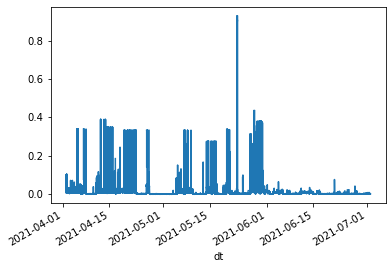

In [28]:
ret_df_04_07.plot()

<AxesSubplot:xlabel='dt'>

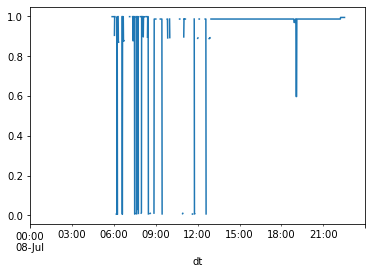

In [74]:
df_2021[(df_2021['dt']>=datetime(2021,7,8,0,0)) & (df_2021['dt']<datetime(2021,7,9,0,0))].set_index('dt')['spread'].plot()

<AxesSubplot:xlabel='dt'>

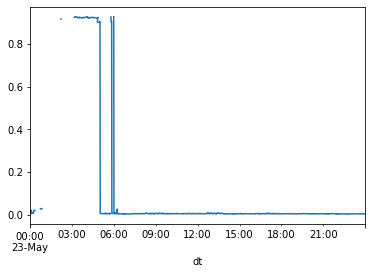

In [ ]:
df_2021[(df_2021['dt']>=datetime(2021,5,23,0,0)) & (df_2021['dt']<datetime(2021,5,24,0,0))].set_index('dt')['spread'].plot()

In [36]:
ret_df_04_07.shape

(129888,)

In [39]:
ret_df_08_10.shape

(166366,)

In [41]:
df_2021 = ret_df_01_03.append(ret_df_04_07).append(ret_df_08_10)

In [62]:
df_2021['date'] = df_2021['dt'].dt.date

In [63]:
df_2021.to_pickle()

,dt,spread,date
0,2021-01-01 00:00:00,0.0460,2021-01-01
1,2021-01-01 00:01:00,0.0400,2021-01-01
2,2021-01-01 00:02:00,0.0410,2021-01-01
3,2021-01-01 00:03:00,0.0405,2021-01-01
4,2021-01-01 00:04:00,0.0395,2021-01-01
...,...,...,...
427280,2021-10-27 23:55:00,0.0015,2021-10-27
427281,2021-10-27 23:56:00,0.0015,2021-10-27
427282,2021-10-27 23:57:00,0.0015,2021-10-27
427283,2021-10-27 23:58:00,0.0015,2021-10-27


### 3) find the spike periods

<AxesSubplot:xlabel='dt'>

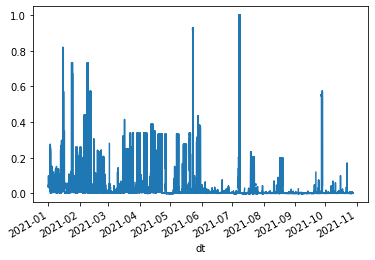

In [43]:
df_2021.plot()

In [60]:
df_2021 = df_2021.reset_index()

#### spikes >=0.5

In [49]:
spikes_lv1 = df_2021[df_2021>=0.5].reset_index()

In [51]:
spikes_lv1['date'] = spikes_lv1['dt'].dt.date

In [53]:
spikes_lv1.groupby('date').count()

,dt,spread
date,,
2021-01-15,5,5
2021-01-23,4,4
2021-01-24,4,4
2021-02-08,34,34
2021-02-11,72,72
2021-05-23,110,110
2021-07-08,701,701
2021-09-27,132,132


dt
2021-09-27    0.011
Name: spread, dtype: float64

<AxesSubplot:xlabel='dt'>

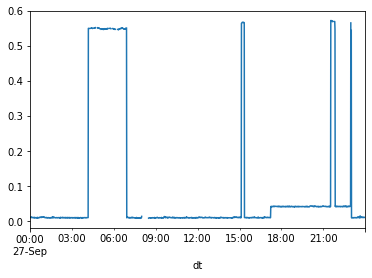

In [73]:
df_2021[(df_2021['dt']>=datetime(2021,9,27,0,0)) & (df_2021['dt']<datetime(2021,9,28,0,0))].set_index('dt')['spread'].plot()

In [ ]:
### check ATM bid/ask quantity, 

In [106]:
ret_dict, ret_df_40C = quoto_and_trade_analysis(contract='BTC-31DEC21-40000-C', date='2021-05-19')

processing data BTC-31DEC21-40000-C 2021-05-19 deribit
'parse_optSymbol_col'  32.68 sec
'parse_time_col'  7.03 sec


In [107]:
ret_dict, ret_df_40P = quoto_and_trade_analysis(contract='BTC-31DEC21-40000-P', date='2021-05-19')

processing data BTC-31DEC21-40000-P 2021-05-19 deribit
'parse_optSymbol_col'  32.25 sec
'parse_time_col'  7.20 sec


In [108]:
ret_dict, ret_df_32P = quoto_and_trade_analysis(contract='BTC-31DEC21-32000-P', date='2021-05-19')

processing data BTC-31DEC21-32000-P 2021-05-19 deribit
'parse_optSymbol_col'  31.99 sec
'parse_time_col'  7.17 sec


In [109]:
ret_dict, ret_df_32C = quoto_and_trade_analysis(contract='BTC-31DEC21-32000-C', date='2021-05-19')

processing data BTC-31DEC21-32000-C 2021-05-19 deribit
'parse_optSymbol_col'  32.06 sec
'parse_time_col'  7.18 sec


In [110]:
ret_dict, ret_df_48C = quoto_and_trade_analysis(contract='BTC-31DEC21-48000-C', date='2021-05-19')

processing data BTC-31DEC21-48000-C 2021-05-19 deribit
'parse_optSymbol_col'  31.96 sec
'parse_time_col'  6.92 sec


In [111]:
ret_dict, ret_df_48P = quoto_and_trade_analysis(contract='BTC-31DEC21-48000-P', date='2021-05-19')

processing data BTC-31DEC21-48000-P 2021-05-19 deribit
'parse_optSymbol_col'  32.30 sec
'parse_time_col'  6.77 sec


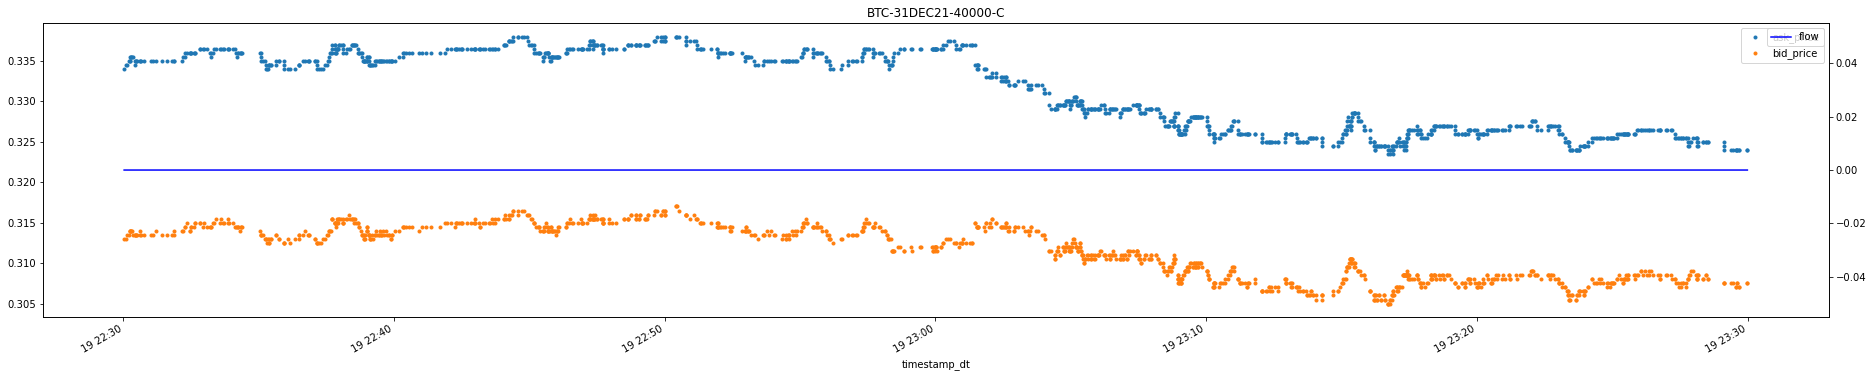

In [131]:
df2plot = ret_df_40C.query('timestamp_dt>=datetime(2021,5,19,22,30)').query('timestamp_dt<=datetime(2021,5,19,23,30)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'])
plt.title('BTC-31DEC21-40000-C')
plt.show()

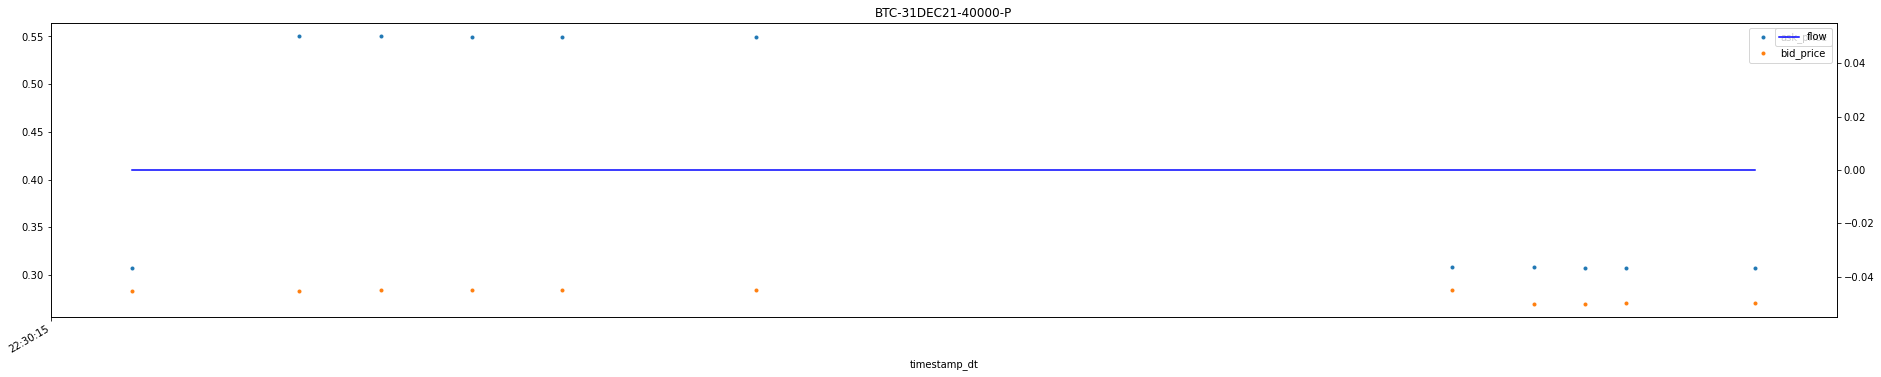

In [149]:
df2plot = ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,22,30,15)').query('timestamp_dt<=datetime(2021,5,19,22,30,20)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'])
plt.title('BTC-31DEC21-40000-P')
plt.show()

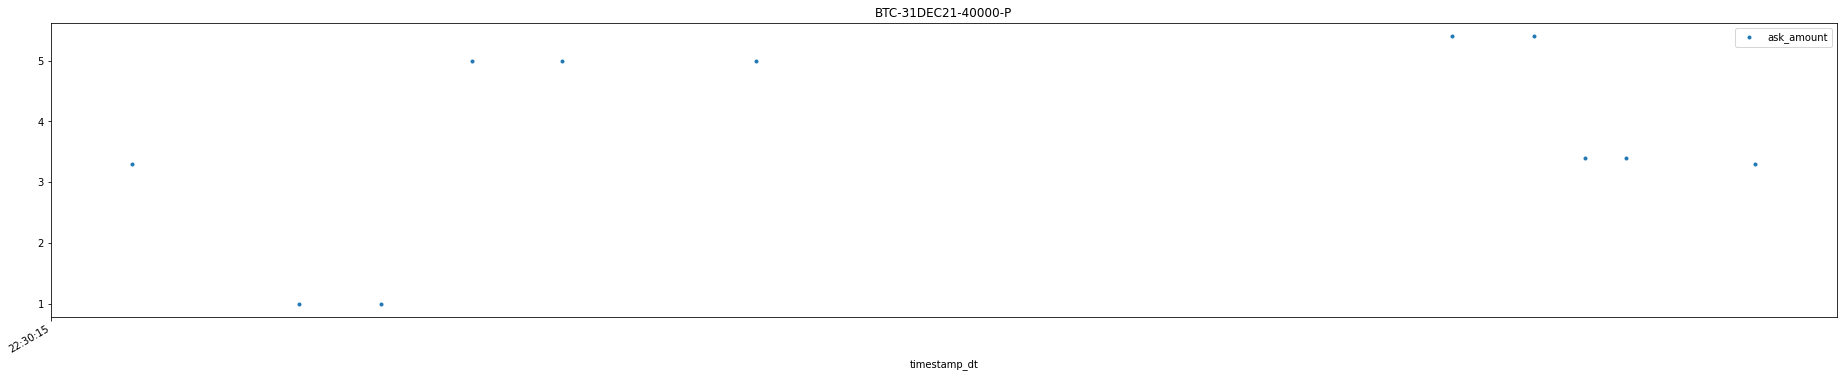

In [150]:
df2plot = ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,22,30,15)').query('timestamp_dt<=datetime(2021,5,19,22,30,20)').set_index('timestamp_dt')[['ask_amount','bid_amount']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_amount',]].plot(ax=ax1, linestyle='None', marker = '.',  legend=['bid_amount'])
plt.title('BTC-31DEC21-40000-P')
plt.show()

In [153]:
ret_df_40P.query('timestamp_dt>=datetime(2021,5,19,22,30,15)').query('timestamp_dt<=datetime(2021,5,19,22,30,20)')[['timestamp_dt','','','','']]

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
54670,deribit,BTC-31DEC21-40000-P,1621463415861000,1621463415921796,3.3,0.3075,0.2835,5.4,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:15.861,5410.0,0.0,NaN,False,0.29550,0.292603,0.022491,0.025920,0.0240
54671,deribit,BTC-31DEC21-40000-P,1621463416251000,1621463416273420,1.0,0.5500,0.2835,5.4,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:16.251,5410.0,0.0,NaN,False,0.41675,0.325141,0.410321,0.111199,0.2665
54672,deribit,BTC-31DEC21-40000-P,1621463416442000,1621463416452199,1.0,0.5500,0.2840,3.8,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:16.442,5410.0,0.0,NaN,False,0.41700,0.339417,0.000600,0.043907,0.2660
54673,deribit,BTC-31DEC21-40000-P,1621463416654000,1621463416659794,5.0,0.5495,0.2840,3.8,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:16.654,5410.0,0.0,NaN,False,0.41675,0.434852,-0.000600,0.281175,0.2655
54674,deribit,BTC-31DEC21-40000-P,1621463416863000,1621463416870749,5.0,0.5495,0.2840,3.7,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:16.863,5410.0,0.0,NaN,False,0.41675,0.436586,0.000000,0.003987,0.2655
54675,deribit,BTC-31DEC21-40000-P,1621463417315000,1621463417322812,5.0,0.5495,0.2840,3.6,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:17.315,5410.0,0.0,NaN,False,0.41675,0.438360,0.000000,0.004064,0.2655
54676,deribit,BTC-31DEC21-40000-P,1621463418939000,1621463418959563,5.4,0.3080,0.2840,3.6,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:18.939,5410.0,0.0,NaN,False,0.29600,0.298400,-0.289742,-0.319282,0.0240
54677,deribit,BTC-31DEC21-40000-P,1621463419130000,1621463419143417,5.4,0.3080,0.2700,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:19.130,5410.0,0.0,NaN,False,0.28900,0.307309,-0.023649,0.029856,0.0380
54678,deribit,BTC-31DEC21-40000-P,1621463419249000,1621463419268961,3.4,0.3075,0.2700,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:19.249,5410.0,0.0,NaN,False,0.28875,0.306429,-0.000865,-0.002865,0.0375
54679,deribit,BTC-31DEC21-40000-P,1621463419345000,1621463419355349,3.4,0.3075,0.2705,5.0,BTC,2021-12-31 08:00:00,...,2021-05-19 22:30:19.345,5410.0,0.0,NaN,False,0.28900,0.285476,0.000866,-0.068376,0.0370


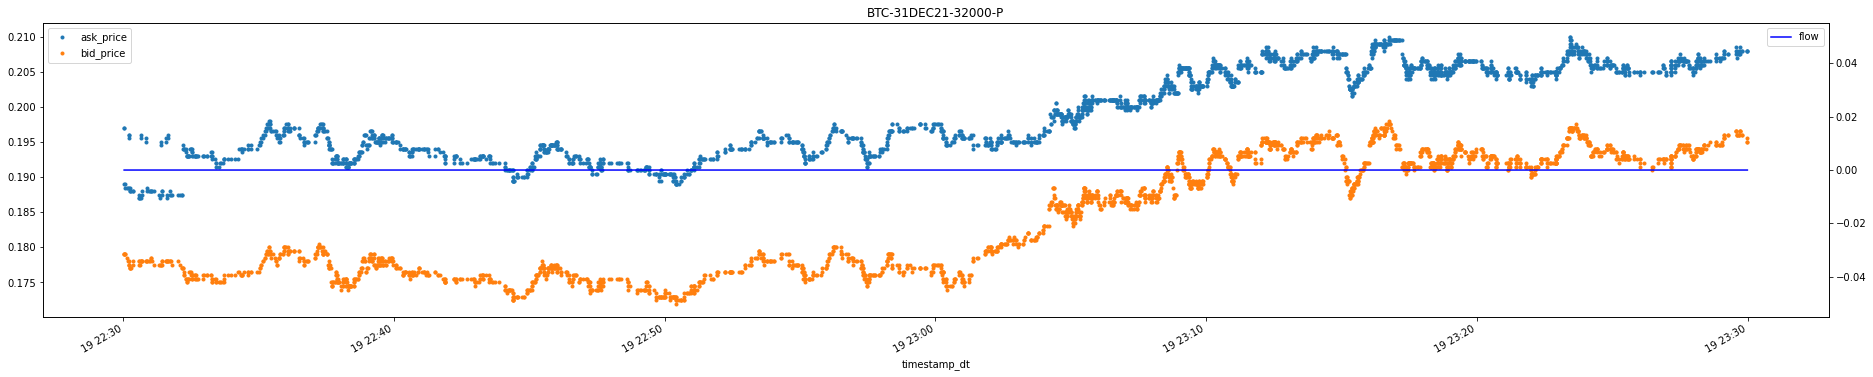

In [133]:
df2plot = ret_df_32P.query('timestamp_dt>=datetime(2021,5,19,22,30)').query('timestamp_dt<=datetime(2021,5,19,23,30)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'])
plt.title('BTC-31DEC21-32000-P')
plt.show()

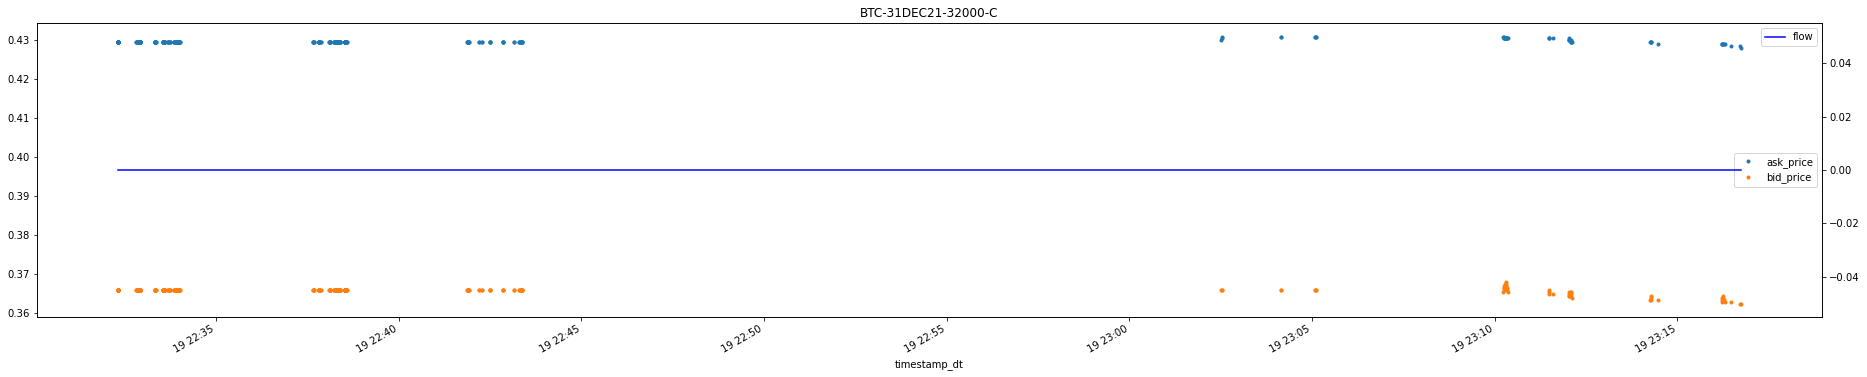

In [134]:
df2plot = ret_df_32C.query('timestamp_dt>=datetime(2021,5,19,22,30)').query('timestamp_dt<=datetime(2021,5,19,23,30)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'])
plt.title('BTC-31DEC21-32000-C')
plt.show()

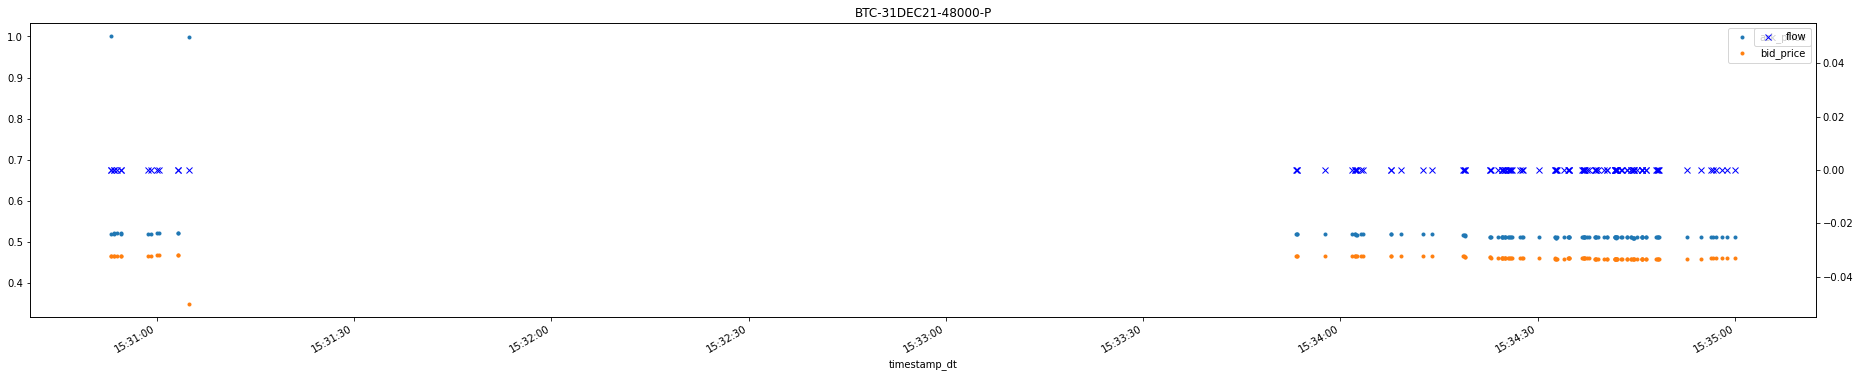

In [190]:
#df2plot = ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,22,30)').query('timestamp_dt<=datetime(2021,5,19,23,30)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
df2plot = ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,15,30)').query('timestamp_dt<=datetime(2021,5,19,15,35)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]

fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'], linestyle='None', marker = 'x')
plt.title('BTC-31DEC21-48000-P')
plt.show()

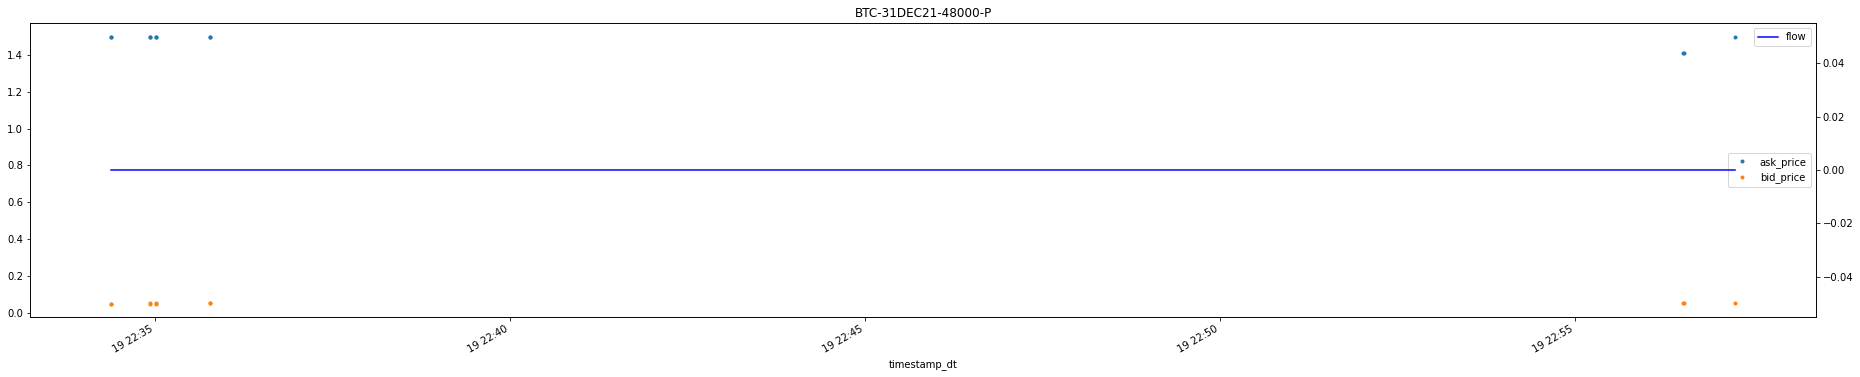

In [136]:
df2plot = ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,22,30)').query('timestamp_dt<=datetime(2021,5,19,23,30)').set_index('timestamp_dt')[['ask_price','bid_price','flow']]
df2plot = ret_df_48P.set_index('timestamp_dt')[['ask_price','bid_price','flow']]
fig, ax1 = plt.subplots(1,1, figsize=(8*4,6))
df2plot[['ask_price','bid_price',]].plot(ax=ax1, linestyle='None', marker = '.')
ax2 = ax1.twinx()
df2plot['flow'].plot(ax=ax2, legend=['trade'], color = ['b'])
plt.title('BTC-31DEC21-48000-P')
plt.show()

In [99]:
df = data_loader(exchange='deribit', date = '2021-05-19', data_type='quotes', symbol='OPTIONS', )

In [103]:
[x for x in list(df['symbol'].unique()) if 'BTC-31DEC21' in x]

['BTC-31DEC21-64000-C',
 'BTC-31DEC21-50000-P',
 'BTC-31DEC21-400000-C',
 'BTC-31DEC21-32000-P',
 'BTC-31DEC21-32000-C',
 'BTC-31DEC21-28000-P',
 'BTC-31DEC21-26000-P',
 'BTC-31DEC21-26000-C',
 'BTC-31DEC21-24000-P',
 'BTC-31DEC21-22000-C',
 'BTC-31DEC21-200000-P',
 'BTC-31DEC21-20000-C',
 'BTC-31DEC21-160000-P',
 'BTC-31DEC21-160000-C',
 'BTC-31DEC21-140000-P',
 'BTC-31DEC21-140000-C',
 'BTC-31DEC21-120000-P',
 'BTC-31DEC21-100000-P',
 'BTC-31DEC21-100000-C',
 'BTC-31DEC21-50000-C',
 'BTC-31DEC21-48000-P',
 'BTC-31DEC21-48000-C',
 'BTC-31DEC21-400000-P',
 'BTC-31DEC21-300000-P',
 'BTC-31DEC21-300000-C',
 'BTC-31DEC21-22000-P',
 'BTC-31DEC21-200000-C',
 'BTC-31DEC21-20000-P',
 'BTC-31DEC21-18000-C',
 'BTC-31DEC21-16000-P',
 'BTC-31DEC21-120000-C',
 'BTC-31DEC21-80000-P',
 'BTC-31DEC21-80000-C',
 'BTC-31DEC21-64000-P',
 'BTC-31DEC21-60000-P',
 'BTC-31DEC21-60000-C',
 'BTC-31DEC21-40000-P',
 'BTC-31DEC21-40000-C',
 'BTC-31DEC21-28000-C',
 'BTC-31DEC21-24000-C',
 'BTC-31DEC21-18000-P',
 '

In [155]:
quoto_and_trade_analysis??

Signature:
quoto_and_trade_analysis(
    contract='BTC-8OCT21-48000-C',
    date='2021-10-01',
    symbol='OPTIONS',
    exchange='deribit',
)
Docstring: <no docstring>
Source:   
def quoto_and_trade_analysis(contract='BTC-8OCT21-48000-C', date ="2021-10-01" , symbol='OPTIONS', exchange='deribit'):
    print('processing data {} {} {}'.format(contract, date, exchange))
    if symbol=='OPTIONS':
        df_opt_quote = data_loader(exchange, date,"quotes",symbol).pipe(DeribitUtils.parse_optSymbol_col).pipe(DeribitUtils.parse_time_col)
        df_opt_trade = data_loader(exchange, date,"trades",symbol).pipe(DeribitUtils.parse_optSymbol_col).pipe(DeribitUtils.parse_time_col)
    else:
        df_opt_quote = data_loader(exchange, date,"quotes",symbol).pipe(DeribitUtils.parse_time_col)
        df_opt_trade = data_loader(exchange, date,"trades",symbol).pipe(DeribitUtils.parse_time_col)
    ATM_btc_c = contract
    
    # processing trade info
    df_opt_trade_i = df_opt_trade.query('symbol==@ATM

In [179]:
exchange = 'deribit'
date = '2021-05-19'
symbol = 'OPTIONS'
df_opt_trade = data_loader(exchange, date,"trades",symbol)

In [180]:
df_opt_trade = df_opt_trade.query('symbol=="BTC-31DEC21-40000-P"')

In [181]:
df_opt_trade['dt'] = pd.to_datetime(df_opt_trade['timestamp'], unit='us') # check convert ts

In [182]:
pd.set_option('display.max_rows', 500)

In [183]:
df_opt_trade.set_index('dt')

,exchange,symbol,timestamp,local_timestamp,id,side,price,amount
dt,,,,,,,,
2021-05-19 01:47:17.470,deribit,BTC-31DEC21-40000-P,1621388837470000,1621388837478349,154160083,buy,0.2980,0.5
2021-05-19 02:07:41.944,deribit,BTC-31DEC21-40000-P,1621390061944000,1621390061965098,154186072,buy,0.3100,1.0
2021-05-19 02:26:39.762,deribit,BTC-31DEC21-40000-P,1621391199762000,1621391199770270,154199474,buy,0.3180,1.0
2021-05-19 02:26:39.764,deribit,BTC-31DEC21-40000-P,1621391199764000,1621391199770312,154199475,sell,0.3180,4.0
2021-05-19 03:27:58.494,deribit,BTC-31DEC21-40000-P,1621394878494000,1621394878500334,154238315,buy,0.2900,0.1
2021-05-19 06:08:51.497,deribit,BTC-31DEC21-40000-P,1621404531497000,1621404531503294,154370619,buy,0.3000,0.1
2021-05-19 06:09:40.623,deribit,BTC-31DEC21-40000-P,1621404580623000,1621404580632156,154370885,buy,0.3000,0.1
2021-05-19 06:11:02.720,deribit,BTC-31DEC21-40000-P,1621404662720000,1621404662731111,154371874,buy,0.2985,0.1
2021-05-19 06:15:38.774,deribit,BTC-31DEC21-40000-P,1621404938774000,1621404938879880,154373918,buy,0.2980,0.1


In [177]:
ret_df_48P.query('timestamp_dt>=datetime(2021,5,19,15,00)').query('timestamp_dt<=datetime(2021,5,19,16,00)')

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,...,timestamp_dt,t2m,flow,has_trade,trade_neighbour,mid_price,wgt_mid_price,midp_chg,wgtmidp_chg,spread
16704,deribit,BTC-31DEC21-48000-P,1621437721972000,1621437722447739,1.0,1.0000,0.3600,14.0,BTC,2021-12-31 08:00:00,...,2021-05-19 15:22:01.972,5417.0,0.0,NaN,False,0.68000,0.402667,0.007407,-0.572045,0.6400
16705,deribit,BTC-31DEC21-48000-P,1621437747673000,1621437747690203,1.0,1.0000,0.3500,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:22:27.673,5417.0,0.0,NaN,False,0.67500,0.940909,-0.007353,1.336695,0.6500
16706,deribit,BTC-31DEC21-48000-P,1621438253125000,1621438253260786,1.0,1.0000,0.4665,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.125,5417.0,0.0,NaN,False,0.73325,0.780324,0.086296,-0.170671,0.5335
16707,deribit,BTC-31DEC21-48000-P,1621438253130000,1621438253260790,0.7,0.5205,0.4665,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.130,5417.0,0.0,NaN,False,0.49350,0.493500,-0.326969,-0.367570,0.0540
16708,deribit,BTC-31DEC21-48000-P,1621438253483000,1621438253707287,0.7,0.5205,0.4670,0.7,BTC,2021-12-31 08:00:00,...,2021-05-19 15:30:53.483,5417.0,0.0,NaN,False,0.49375,0.493750,0.000507,0.000507,0.0535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17919,deribit,BTC-31DEC21-48000-P,1621439440702000,1621439440713160,0.7,0.4970,0.4545,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.702,5417.0,0.0,NaN,False,0.47575,0.460571,-0.000525,-0.038990,0.0425
17920,deribit,BTC-31DEC21-48000-P,1621439440813000,1621439440842870,0.7,0.4970,0.4535,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.813,5417.0,0.0,NaN,False,0.47525,0.459714,-0.001051,-0.001861,0.0435
17921,deribit,BTC-31DEC21-48000-P,1621439440814000,1621439440963097,5.0,0.4965,0.4535,4.2,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:40.814,5417.0,0.0,NaN,False,0.47500,0.476870,-0.000526,0.037317,0.0430
17922,deribit,BTC-31DEC21-48000-P,1621439449887000,1621439450422864,5.0,0.9995,0.3500,0.1,BTC,2021-12-31 08:00:00,...,2021-05-19 15:50:49.887,5417.0,0.0,NaN,False,0.67475,0.986765,0.420526,1.069255,0.6495
